In [1]:
import random
import operator
import math
import numpy as np
from deap import creator, base, tools, algorithms,gp
import matplotlib.pyplot as plt
import networkx as nx
import pygraphviz as pgv
from IPython.display import Image 

In [2]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

In [3]:
pset = gp.PrimitiveSet("MAIN",0)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addTerminal(2)
pset.addTerminal(5)
pset.addTerminal(8)

In [4]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [5]:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [6]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [18]:
expr = toolbox.individual()
nodes, edges, labels = gp.graph(expr)

tree = gp.PrimitiveTree(expr)
string_tree = str(tree)
print(string_tree)

mul(2, mul(protectedDiv(protectedDiv(2, 5), 2), mul(sub(5, 2), 5)))


In [19]:
function = toolbox.compile(expr=tree)

In [20]:
function

6.0

In [21]:
g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

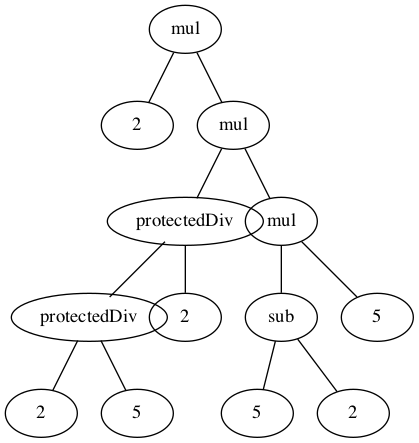

In [22]:
for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("./figures/tree.png")

pil_img = Image(filename='./figures/tree.png')
display(pil_img)

In [ ]:
def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(x) - x**4 - x**3 - x**2 - x)**2 for x in points)
    return math.fsum(sqerrors) / len(points),

In [ ]:
toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,10)])
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [ ]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

In [ ]:
pop = toolbox.population(n=300)

In [ ]:
hof = tools.HallOfFame(1)

In [ ]:
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats,
                                   halloffame=hof, verbose=True)

### TEST

In [ ]:
pset = gp.PrimitiveSet("main", 2)
pset.addPrimitive(max, 2)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.mul, 2)
pset.addTerminal(3)
pset.renameArguments(ARG0="x")
pset.renameArguments(ARG1="y")

In [ ]:
expr = gp.genFull(pset, min_=1, max_=3)
tree = gp.PrimitiveTree(expr)

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin,
               pset=pset)

In [ ]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.expr)

In [ ]:
expr = gp.genFull(pset, min_=1, max_=3)

In [ ]:
tree = gp.PrimitiveTree(expr)

In [ ]:
str(tree)

In [ ]:
function = compile(str(tree), pset)